# Predicting heart disease

The World Health Organization (WHO) estimates that 17.9 million people die from cardiovascular diseases (CVDs) every year.

There are multiple risk factors that could contribute to CVD in an individual, such as unhealthy diet, lack of physical activity, or mental illness. Identifying these risk factors early on could help prevent many premature deaths.

Let's assume we are working for an R&D company that focuses on providing healthcare solutions. The company has collected anonymized data from multiple hospitals on several patients. The [dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction) includes relevant information for each patient, such as their personal information and some medical data, including whether or not they have had heart disease before.

We are tasked with using the dataset to accurately predict the likelihood of a new patient having heart disease in the future.

## Exploring the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
%matplotlib inline

heart = pd.read_csv('heart_disease_prediction.csv')

print(heart.info())
print(heart.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160

In [2]:
print(heart.shape)

(918, 12)


We can see that this dataset has 918 cases and 12 variables. Our outcome variable of interest is `HeartDisease`, which is 1 for patients that suffered from a heart disease and 0 for those that didn't. We have 11 features at our disposal to predict this outcome. Luckily, none of the columns contains any missing values.

## Descriptive statistics

Let's start by exploring and analyzing the numerical columns.

In [3]:
num_vars = heart.columns[heart.dtypes != 'object']
print(heart[num_vars].describe())

              Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  918.000000  918.000000   918.000000  918.000000  918.000000   
mean    53.510893  132.396514   198.799564    0.233115  136.809368   
std      9.432617   18.514154   109.384145    0.423046   25.460334   
min     28.000000    0.000000     0.000000    0.000000   60.000000   
25%     47.000000  120.000000   173.250000    0.000000  120.000000   
50%     54.000000  130.000000   223.000000    0.000000  138.000000   
75%     60.000000  140.000000   267.000000    0.000000  156.000000   
max     77.000000  200.000000   603.000000    1.000000  202.000000   

          Oldpeak  HeartDisease  
count  918.000000    918.000000  
mean     0.887364      0.553377  
std      1.066570      0.497414  
min     -2.600000      0.000000  
25%      0.000000      0.000000  
50%      0.600000      1.000000  
75%      1.500000      1.000000  
max      6.200000      1.000000  


In [4]:
print(heart[heart['RestingBP'] == 0].shape)
print(heart[heart['Cholesterol'] == 0].shape)

(1, 12)
(172, 12)


The average age of the patients in our sample is 53.51 years, with the youngest patients being 28 years old and the oldest patient 77 years old. Looking at the other numeric variables, two might deserve further scrutiny for their value ranges.

For example `RestingBP` (resting blood pressure \[mm Hg\]) with a value of 0 seems wrong, as a patient without blood pressure would be dead. Luckily, this is only 1 case. Another problematic columns seems to be `Cholesterol` (serum cholesterol \[mm/dl\]). Here we have 172 cases with zero values. It's highly implausible that a cholesterol measure would be 0, so we might assume that these actually are cases of missing data.

The other numeric variables seem to be ok, or at least they are within the ranges that are mentioned within the dataset description.

## Some visualizations

We'll explore the categorical features next, but we'll rely on creating visualizations to understand how the data is distributed. Even though some of the variable values are integers, we can consider them categorical variables, as they only indicate binary categories, e.g. `FastingBS`, which is 1 for > 120 mg/dl fasting blood sugar and 0 otherwise. Let us plot the frequencies of these variables and split them up by  `HeartDisease`.

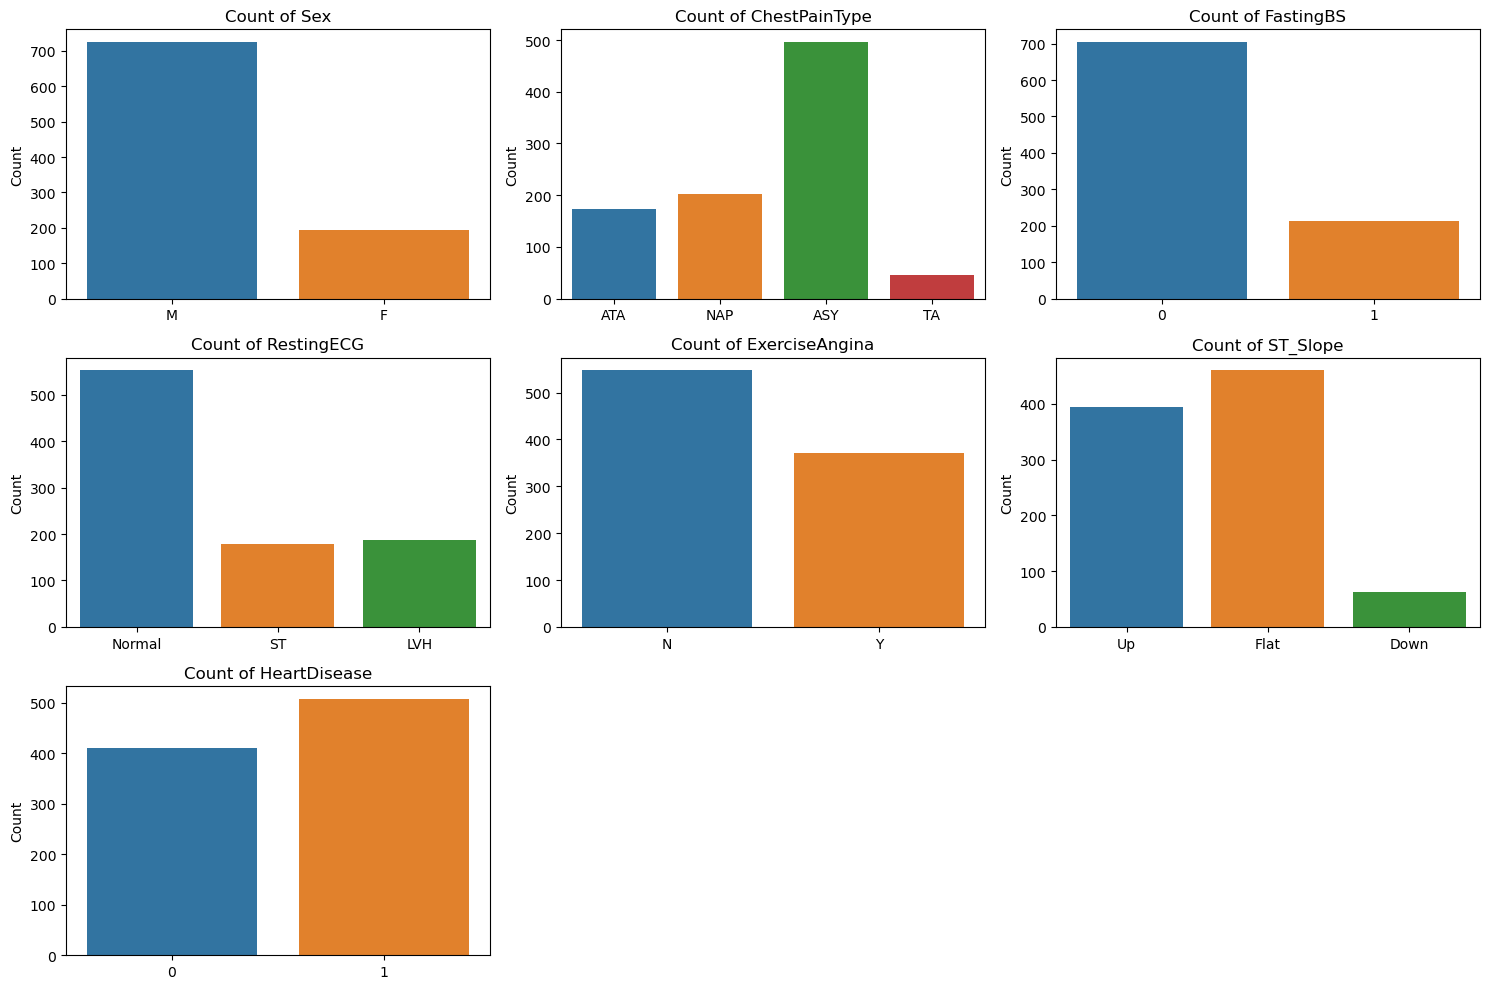

In [5]:
categorical = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease']

# Define columns and rows
n_cols = 3
n_rows = (len(categorical) + n_cols - 1) // n_cols  # rows calculated based on cols

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))

# Turn multicol-multirow matrix of subplot into just a row-vector for iteration
axes = axes.flatten()

# Loop through the categorical variables and create a count plot for each
for i, col in enumerate(categorical):
    sns.countplot(data=heart, x=col, ax=axes[i])
    axes[i].set_title(f'Count of {col}')
    axes[i].set_xlabel('')  # Removes the x-axis label to avoid clutter
    axes[i].set_ylabel('Count')

# Remove any empty subplots (if there are fewer plots than grid spaces)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

We can gather some valuable first insights from the simple counts:
- The majority of patients in our sample are male, potentially because they are more likely to seek treatment for heart disease
- The most reported chest pain type is `ASY`, meaning "Asymptomatic". This implies that most cases in our smaple don't report symptoms. The `TA`category ("Typical Angina") is fairly rare, and `ATA` ("Atypical Angina") and `NAP` ("Non-Anginal Pain") occur about equally often.
- The majority of cases has no elevated fasting blood sugar levels (`FastingBS`).
- Most patients are have a "normal" `RestingECG`. ST-T wave abnormality (`ST`) and probable or definite left ventricular hypertrophy (`LVH`) occur roughly equally often.
- While most people don't report exercise induced Angina (`ExerciseAngina`), there is a fair number of people that do.
- The `ST_Slope` is a measure taken during exercise. We see that in most cases it's flat, second most we observe an upward slope, and downward-slope seems rare.
- The count of `HeartDisease`, lastly, tells us that slightly more than half of our sample are eventually diagnosed with a heart disease. This is certainly interesting as most cases are asymptomatic.

What can we learn when we split the data for those being diagnosed with heart disease vs those that are not diagnosed?

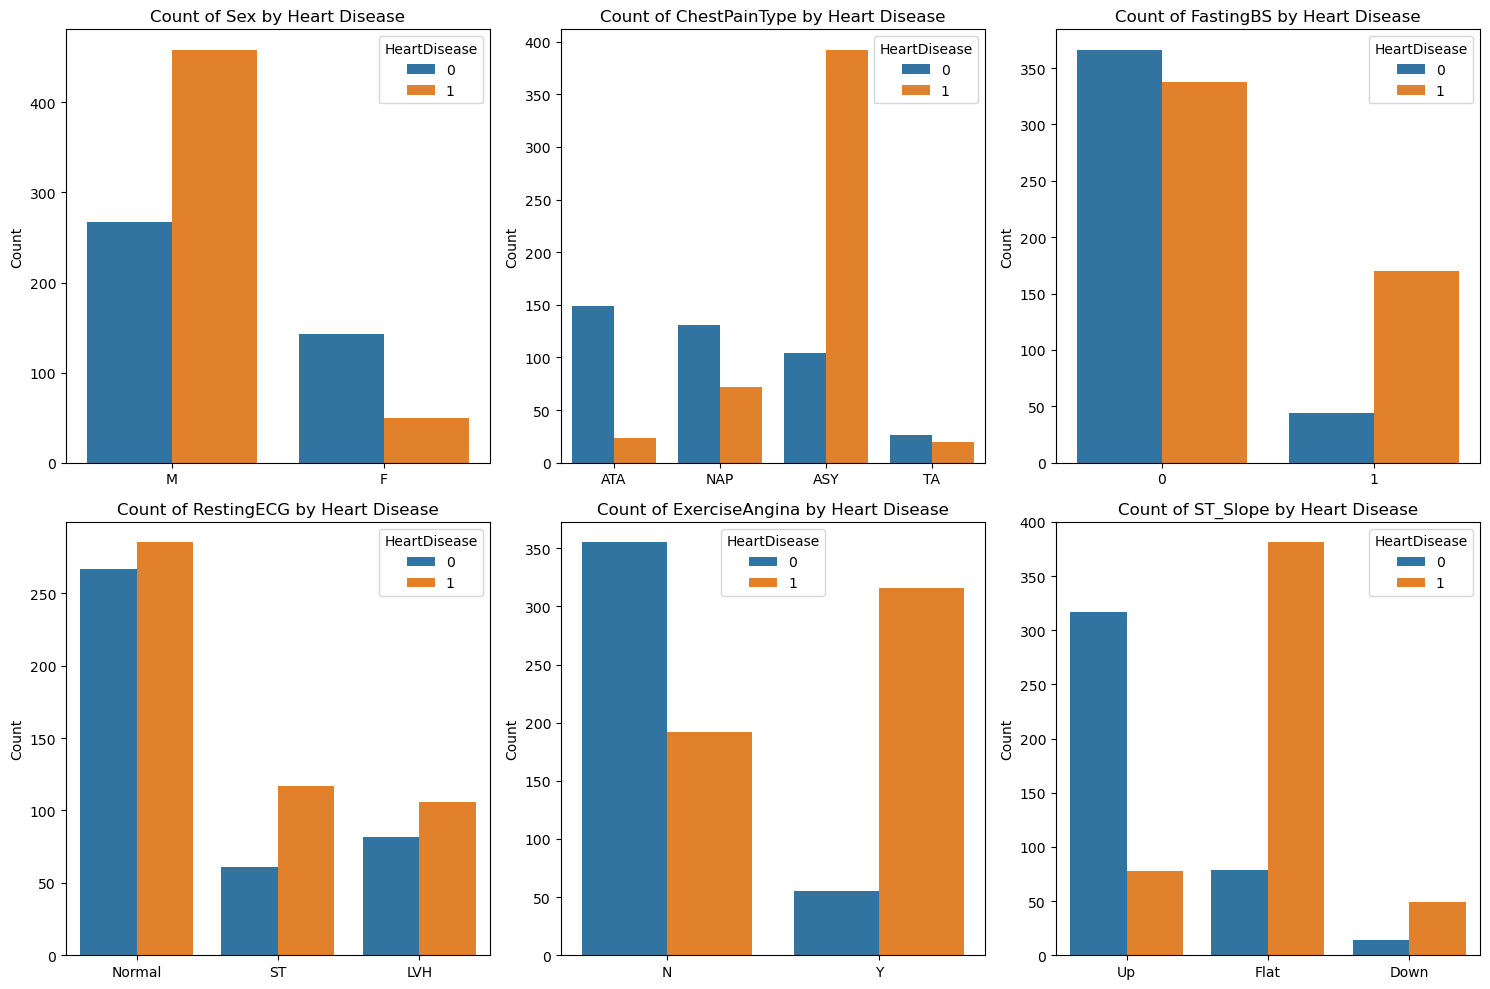

In [6]:
# All columns except for HeartDisease
categorical = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

# Define columns and rows
n_cols = 3
n_rows = (len(categorical) + n_cols - 1) // n_cols  

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))

# Turn multicol-multirow matrix of subplot into just a row-vector for iteration
axes = axes.flatten()

# Loop through the categorical variables and create a count plot for each
for i, col in enumerate(categorical):
    sns.countplot(data=heart, x=col, hue='HeartDisease', ax=axes[i])
    axes[i].set_title(f'Count of {col} by Heart Disease')
    axes[i].set_xlabel('')  # Optional: remove the x-axis label to avoid clutter
    axes[i].set_ylabel('Count')

# Remove any empty subplots 
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

Again, there ar a number of interesting insights:
- Men are much more overrepresented in the group of people with a heart disease
- Surprisingly, the highest count of heart diseases is observed in the asymptomatic `ChestPain Type` group.
- While low and high fasting blood sugar leves are about equally likely among the non-heart disease group, among those with a heart disease, high blood sugar levels are much more likely than low levels.
- ST-T wave abnormality (`ST`) and probable or definite left ventricular hypertrophy (`LVH`) occur relatively more often in the group of persons with a heart disease.
- Exercies induced Angina is very comonly observed among those diagnosed with a heart disease.
- An indicator that seems to discriminate well between heart diseas and no heart disease is the ST slope measure. Among those with a hear disease, it's much more likely to be flat.

## Data cleaning

We overall did not find any values that were explicitly recorded as missing values. However, we found anomalies for `RestingBP`and `Cholesterol`. While more complex stratgies would be possible, we will handle these cases in a more simple way.
- Since we only have one case of `RestingBP` being 0, we will remove this row.
- For the 172 cases of `Cholesterol` being recorded as 0, we will replace these values with the median value of the corresponding column and the corresponding `HeartDisease` value.

In [7]:
# Drop RestingBP == 0
heart = heart[heart['RestingBP'] != 0]

In [8]:
# Determine median Cholesterol values
median_cholesterol_nodisease = np.median(heart[heart['HeartDisease'] == 0]['Cholesterol'])
print(median_cholesterol_nodisease)

median_cholesterol_disease = np.median(heart[heart['HeartDisease'] == 1]['Cholesterol'])
print(median_cholesterol_disease)

227.0
217.0


In [9]:
# Replace Cholesterol values
heart.loc[(heart['Cholesterol'] == 0) & (heart['HeartDisease'] == 0), 'Cholesterol'] = median_cholesterol_nodisease
heart.loc[(heart['Cholesterol'] == 0) & (heart['HeartDisease'] == 1), 'Cholesterol'] = median_cholesterol_disease

In [10]:
print(heart.shape)

(917, 12)


In [11]:
print(heart[num_vars].describe())

              Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  917.000000  917.000000   917.000000  917.000000  917.000000   
mean    53.509269  132.540894   239.700109    0.233370  136.789531   
std      9.437636   17.999749    54.352727    0.423206   25.467129   
min     28.000000   80.000000    85.000000    0.000000   60.000000   
25%     47.000000  120.000000   214.000000    0.000000  120.000000   
50%     54.000000  130.000000   225.000000    0.000000  138.000000   
75%     60.000000  140.000000   267.000000    0.000000  156.000000   
max     77.000000  200.000000   603.000000    1.000000  202.000000   

          Oldpeak  HeartDisease  
count  917.000000    917.000000  
mean     0.886696      0.552890  
std      1.066960      0.497466  
min     -2.600000      0.000000  
25%      0.000000      0.000000  
50%      0.600000      1.000000  
75%      1.500000      1.000000  
max      6.200000      1.000000  


As expected, we now lost one case, and we have a less skewed `Cholesterol`distribution in our data. 

## Feature selection

Now that we've cleaned our data, we can select features for our model. Thanks to our exploratory data analysis and a general understanding of the features, we can identify some of the features that we could start with:

- Age
- Sex
- ChestPainType
- Cholesterol
- FastingBS

In [12]:
# Convert categorical variables into dummies (reference categories dropped)

heart = pd.get_dummies(data = heart, drop_first = False, dtype=float)

In [13]:
# Calculate correlations

correlations = heart.corr()
print(correlations)

                        Age  RestingBP  Cholesterol  FastingBS     MaxHR  \
Age                1.000000   0.263084     0.026756   0.198170 -0.382280   
RestingBP          0.263084   1.000000     0.092169   0.067823 -0.109693   
Cholesterol        0.026756   0.092169     1.000000  -0.023912  0.037959   
FastingBS          0.198170   0.067823    -0.023912   1.000000 -0.131067   
MaxHR             -0.382280  -0.109693     0.037959  -0.131067  1.000000   
Oldpeak            0.258563   0.174252     0.057086   0.053062 -0.161213   
HeartDisease       0.282012   0.117990     0.024914   0.267994 -0.401410   
Sex_F             -0.055670  -0.009427     0.132268  -0.120424  0.189668   
Sex_M              0.055670   0.009427    -0.132268   0.120424 -0.189668   
ChestPainType_ASY  0.166903   0.041568     0.044584   0.130629 -0.354444   
ChestPainType_ATA -0.218113  -0.051374     0.020929  -0.140844  0.254214   
ChestPainType_NAP -0.011681  -0.027536    -0.053205  -0.038201  0.133411   
ChestPainTyp

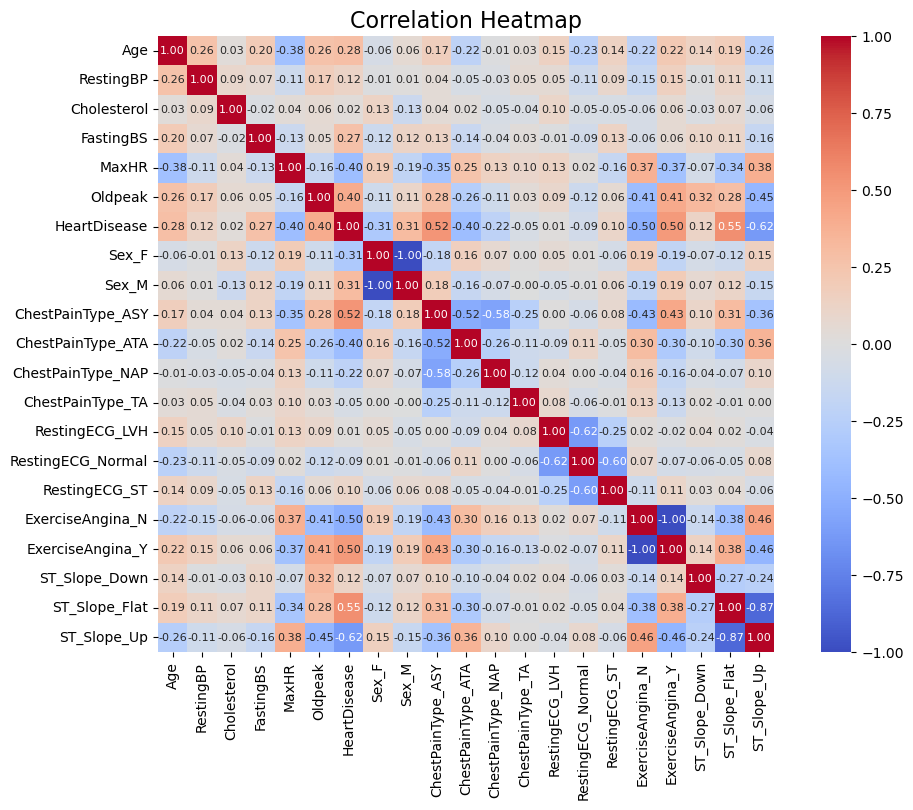

In [14]:
# Heatmap

plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True, annot_kws={"size": 8})
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

In [15]:
# Five highest absolute correlations with HeartDisease

print(abs(correlations['HeartDisease']).sort_values(ascending=False).head(10))

HeartDisease         1.000000
ST_Slope_Up          0.621843
ST_Slope_Flat        0.553700
ChestPainType_ASY    0.518339
ExerciseAngina_Y     0.495490
ExerciseAngina_N     0.495490
Oldpeak              0.403638
ChestPainType_ATA    0.401680
MaxHR                0.401410
Sex_F                0.305118
Name: HeartDisease, dtype: float64


In [16]:
# Five highest absolute correlations (squared) with HeartDisease

print(((correlations['HeartDisease']) ** 2).sort_values(ascending=False).head(10))

HeartDisease         1.000000
ST_Slope_Up          0.386688
ST_Slope_Flat        0.306584
ChestPainType_ASY    0.268675
ExerciseAngina_Y     0.245510
ExerciseAngina_N     0.245510
Oldpeak              0.162924
ChestPainType_ATA    0.161346
MaxHR                0.161130
Sex_F                0.093097
Name: HeartDisease, dtype: float64


With all categorical variables turned into dummies and expecting the correlations, we see that `ST_Slope_Up`, `ST_Slope_Flat`, `ChestPainType_ASY`, `ExerciseAngina_Y` (reference category: `ExerciseAngina_N`) have the five highest absolute correlations, followed by `Oldpeak`, `ChestPainType_ATA`, `MaxHR`, and `Sex_F`. Looking at the squared correlation coefficients does not add new information here. While the squred r in a single predictor regression can be interpreted as the variance explained, this is a less approproate interpretation for our binary outcome variable. After cleaning up the `Cholesterol` data, it is not a very pronounced predictor anymore, and `age`does not explain a lot of heart disease outcomes either. We pick the top five correlated variables, plus any features that seem interesting from the exploration above.

Based on this and our exploratory data analysis, we choose the following features to be included in our model:

- `ST_Slope_Up` 
- `ST_Slope_Flat`
- `ChestPainType_ASY`
- `ExerciseAngina_Y`
- `Oldpeak` 
- `Sex_M`

## Building a classifier

Next, we will create and train multiple models using one of those features at a time. We start by creating trainnig, validaton, and test sets. We will use 60% of our data for training, 20% for validation and 20% for testing.

In [17]:
# Creating training, validation, and test sets

features = ['ST_Slope_Up', 'ST_Slope_Flat', 'ChestPainType_ASY', 'ExerciseAngina_Y', 'Oldpeak', 'Sex_M']
X = heart.loc[:, features]
y = heart['HeartDisease']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=23)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=23)

We now evaluate a k-NN classifier using one feature at a time for 3, 5, and 10 neighbours. 

In [18]:
# Evaluate k-NN classifier, one feature at a time, using different k values

k_values = [3, 5, 10]
accuracies = {}

def evaluate_model(k, feature):
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', p=2)
    knn.fit(X_train[[feature]], y_train)
    train_accuracy = knn.score(X_train[[feature]], y_train)
    validate_accuracy = knn.score(X_val[[feature]], y_val)
    return train_accuracy, validate_accuracy

for feature in features:
    for k in k_values:
        train_accuracy, validate_accuracy = evaluate_model(k, feature)
        accuracies[(k, feature)] = round(validate_accuracy, 3)

df_accuracies = pd.DataFrame(
    [(k, feature, accuracy) for (k, feature), accuracy in accuracies.items()],
    columns=['k', 'Feature', 'Accuracy']
)

df_accuracies

,k,Feature,Accuracy
0,3,ST_Slope_Up,0.451
1,5,ST_Slope_Up,0.815
2,10,ST_Slope_Up,0.815
3,3,ST_Slope_Flat,0.788
4,5,ST_Slope_Flat,0.788
5,10,ST_Slope_Flat,0.788
6,3,ChestPainType_ASY,0.793
7,5,ChestPainType_ASY,0.793
8,10,ChestPainType_ASY,0.793
9,3,ExerciseAngina_Y,0.723


The above DataFrame shows the accuracies of the k-NN classifier, evaluated on the validation dataset, when we only use one feature at a time.
We see that the number of neighbours for `ST_Slope_Up`and `Sex_M`, where `k=3` performs a lot worse than either `k=5`or `k=10`. In those cases the accuracy is merely 45.1% each. Thus choosing `k>=5` seems to be a good choice.

Secondly, we see that if `k>=5`, all features perform in the rank ordering of their simple bivariate correlations with the `HeartDisease`. It is not clear whether `Sex_M`, with its accuracy of 63% needs to be included in a model with more features, since it's performing comparatively worse than all other features.

We can now move on to the next step, where we will apply approproate scaling and build a classifier with multiple features.

## Building a classifier with multiple features

We will now use all of thes efeatures together and see how much we can improve the accuracy through this. We start by normalizing the features first.

In [19]:
# Scaling features to the range (0,1)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [20]:
# Evaluating the new classifier

k_values = [3, 5, 10]
accuracies = {}

def evaluate_model(k):
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', p=2)
    knn.fit(X_train, y_train)
    train_accuracy = knn.score(X_train, y_train)
    validate_accuracy = knn.score(X_val, y_val)
    return train_accuracy, validate_accuracy

for k in k_values:
    train_accuracy, validate_accuracy = evaluate_model(k)
    accuracies[k] = round(validate_accuracy, 3)

print(accuracies)

{3: 0.804, 5: 0.81, 10: 0.81}


In [21]:
# Evaluating the new classifier (dropping Sex_M)

k_values = [3, 5, 10]
accuracies = {}

def evaluate_model(k):
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', p=2)
    knn.fit(X_train[['ST_Slope_Up', 'ST_Slope_Flat', 'ChestPainType_ASY', 'ExerciseAngina_Y', 'Oldpeak']], y_train)
    train_accuracy = knn.score(X_train[['ST_Slope_Up', 'ST_Slope_Flat', 'ChestPainType_ASY', 'ExerciseAngina_Y', 'Oldpeak']], y_train)
    validate_accuracy = knn.score(X_val[['ST_Slope_Up', 'ST_Slope_Flat', 'ChestPainType_ASY', 'ExerciseAngina_Y', 'Oldpeak']], y_val)
    return train_accuracy, validate_accuracy

for k in k_values:
    train_accuracy, validate_accuracy = evaluate_model(k)
    accuracies[k] = round(validate_accuracy, 3)
    
print(accuracies)

{3: 0.821, 5: 0.832, 10: 0.832}


There are two things to note here. Looking first at the classifier with all selected features, we see that it will yield an accuracy on the validation dataset of 0.804 for `k=3` and 0.81 for `k>=5`. That seems fine, however, it's not actually much better than using only `ST_Slope_Up` feature on its own. (We even had a slightly better accuracy of 0.815.)

Secondly, we can see whether dropping the worst performing feature from the model will improve its accuracy. Therefore we ran another instance of the classifier and dropped `Sex_M`. Given that we at least use `k=5`, we are able to slightly improve the accuracy of our classifier to 0.832. 

## Hyperparameter tuning

Now that we have a reasonably well-performing model, we can experiment with the parameters and hyperparameters. We'll use `GridSearchCV` to search over those values. While `Sex_M` did not improve the accuracy, we will leave it in the model, as dropping it might leave the data too unbalanced. We already created the test dataset above and will now just apply the scaling to it.

In [22]:
# Scaling the test data

X_test_scaled = scaler.transform(X_test)

In [23]:
# Grid search

hyperparameters = {'n_neighbors': k_values, 'weights': ['uniform', 'distance'], 'p': list(range(1, 6))}
knn = KNeighborsClassifier()
clf = GridSearchCV(estimator=knn, param_grid=hyperparameters, scoring='accuracy')
clf.fit(X_train_scaled, y_train)
results = pd.DataFrame(clf.cv_results_)

In [24]:
results.sort_values('rank_test_score', ascending=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
26,0.000515,0.000014,0.010162,0.012035,10,4,uniform,"{'n_neighbors': 10, 'p': 4, 'weights': 'uniform'}",0.836364,0.845455,0.863636,0.854545,0.844037,0.848807,0.009399,1
24,0.000535,0.000041,0.004230,0.000157,10,3,uniform,"{'n_neighbors': 10, 'p': 3, 'weights': 'uniform'}",0.836364,0.845455,0.863636,0.854545,0.844037,0.848807,0.009399,1
20,0.000504,0.000014,0.002529,0.000011,10,1,uniform,"{'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}",0.836364,0.845455,0.863636,0.854545,0.844037,0.848807,0.009399,1
28,0.000528,0.000006,0.004243,0.000046,10,5,uniform,"{'n_neighbors': 10, 'p': 5, 'weights': 'uniform'}",0.836364,0.845455,0.863636,0.854545,0.844037,0.848807,0.009399,1
0,0.000529,0.000032,0.012205,0.019289,3,1,uniform,"{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}",0.800000,0.845455,0.881818,0.845455,0.862385,0.847023,0.027066,5
2,0.000528,0.000049,0.002526,0.000179,3,2,uniform,"{'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}",0.800000,0.845455,0.881818,0.845455,0.862385,0.847023,0.027066,5
4,0.000514,0.000017,0.003937,0.000061,3,3,uniform,"{'n_neighbors': 3, 'p': 3, 'weights': 'uniform'}",0.800000,0.845455,0.881818,0.845455,0.862385,0.847023,0.027066,5
6,0.000516,0.000013,0.003940,0.000041,3,4,uniform,"{'n_neighbors': 3, 'p': 4, 'weights': 'uniform'}",0.800000,0.845455,0.881818,0.845455,0.862385,0.847023,0.027066,5
8,0.000509,0.000012,0.003909,0.000035,3,5,uniform,"{'n_neighbors': 3, 'p': 5, 'weights': 'uniform'}",0.800000,0.845455,0.881818,0.845455,0.862385,0.847023,0.027066,5
22,0.000498,0.000016,0.008532,0.012113,10,2,uniform,"{'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}",0.836364,0.845455,0.854545,0.854545,0.844037,0.846989,0.006902,10


In [25]:
best_score = results[results['rank_test_score'] == 1]['mean_test_score'].iloc[0]
best_params = results[results['rank_test_score'] == 1]['params'].iloc[0]

print(best_score)
print(best_params)

0.8488073394495412
{'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}


Based on this grid search, we find the following results, evaluating the model on our training data:

The best model accuracy that we were able to achieve is  ca. 0.85, while using the features `['ST_Slope_Up', 'ST_Slope_Flat', 'ChestPainType_ASY', 'ExerciseAngina_Y', 'Oldpeak', 'Sex_M']`. The best combination of hyperparameters is running the k-NN classifier with 10 neighbours, using power parameter `p=1` for the Minkowski metric (although any in the range 1-4 would work fine), and using uniform weights.

We started with a classifier that only used one feature at a time and found that `ST_Slope_Up` alone will be accurate to 81.5%. Slight improvements, by dropping `Sex_M` and scaling appropriately up to 83.2% accuracy were achieved.

Finally, tweaking the hyperparameters further, allowed us to achieve an accuracy of 84.9%. 
This is not a great improvement, but we could potentially do better by focussing on a more balanced dataset (i.e. only using male participants) to further reduce variation. (Of course, additional analyses would need to be performed on an all-female sample too.)

## Model evaluation on test set

We'll now evaluate this model on our test set. Recall that we need to normalize our test set and use the same scaler we created earlier. However, this time we'll only transform the test set and not fit the scaler on it.

In [27]:
# Evaluation on the test data using the best estimator
best_knn_model = clf.best_estimator_
y_pred = best_knn_model.predict(X_test_scaled)

accuracy2 = accuracy_score(y_test, y_pred)
print(accuracy2)

0.8532608695652174


We find that when we apply our classifier to the test data that we only achieve an accuracy of 85.3%. This is a reasonable performance, but not a strong improvement overall. As previously discussed, we might improve our accuracy by splitting the data into a sample of only males and only females. Given the rather small sample, we might be able to improve the accuracy by reducing the number of features, as we might be overfitting the data in the training sample, leading to reduced accuracy in the test data.